In [1]:
import numpy as np
import torch
from tqdm import tqdm

from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A

from model.FoodDataset import FoodDataset
from model.architectures.unet import Unet_model

In [2]:
image_dir = ["E:\Licenta_DOC\API_Segmentation\data\generated\img_dir"]
seg_paths = ["E:\Licenta_DOC\API_Segmentation\data\generated\\ann_dir"]
LOAD_MODEL = True
def get_images(transform = None,batch_size=32,shuffle=True,pin_memory=True):
    data = FoodDataset(image_dir,seg_paths, transform = transform)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch


In [3]:

t1 = A.Compose([
    A.Resize(256,256),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

train_batch,test_batch = get_images(transform =t1,batch_size=8)



In [4]:

from model.checkpoints import load_checkpoint

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet_model().to(DEVICE)
if LOAD_MODEL:
    load_checkpoint(torch.load('checkpoint-ce_dice_loss.pth.tar'), model)


In [5]:
file = open("loss_data/unet_IoU_data.csv", "a")

In [6]:
from model.losses.ce_iou_loss import CE_IOU_Loss
from torchsummary import summary
summary(model, (3, 256, 256))

LEARNING_RATE = 1e-4
num_epochs = 2

loss_fn = CE_IOU_Loss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    epoch_loss = 0.0

    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    avg_loss = epoch_loss / loop.total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    file.write(f"{epoch+1},{avg_loss:.4f}\n")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
    Encoding_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

  1%|          | 23/2848 [02:19<4:46:18,  6.08s/it, loss=1.12]


KeyboardInterrupt: 

In [7]:
from model.checkpoints import save_checkpoint

# save checkpoint
checkpoint =  {"state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict()
           }
save_checkpoint(checkpoint,'checkpoint-ce_dice_loss.pth.tar' )



=>saving checkpoint to checkpoint-ce_dice_loss.pth.tar


In [8]:

def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    iou = 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            intersection = torch.logical_and(preds, y).sum()
            union = torch.logical_or(preds, y).sum()
            iou += (intersection + 1e-8) / (union + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    print(f"IoU: {iou/len(loader)}")
    model.train()



In [9]:
# print("Train")
# check_accuracy(train_batch, model)

In [10]:

print("Test")
check_accuracy(test_batch, model)

Test
Got 100791278/157286400 with acc 64.08
Dice score: 56.14209747314453
IoU: 0.8384243845939636


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pred1 (array([ 0,  3, 37, 44, 46, 48, 58, 59, 70], dtype=int64), array([29235,    78,   155,    26,   193,  2335, 32522,    22,   970],
      dtype=int64))
Mask1 [ 0 29 58]


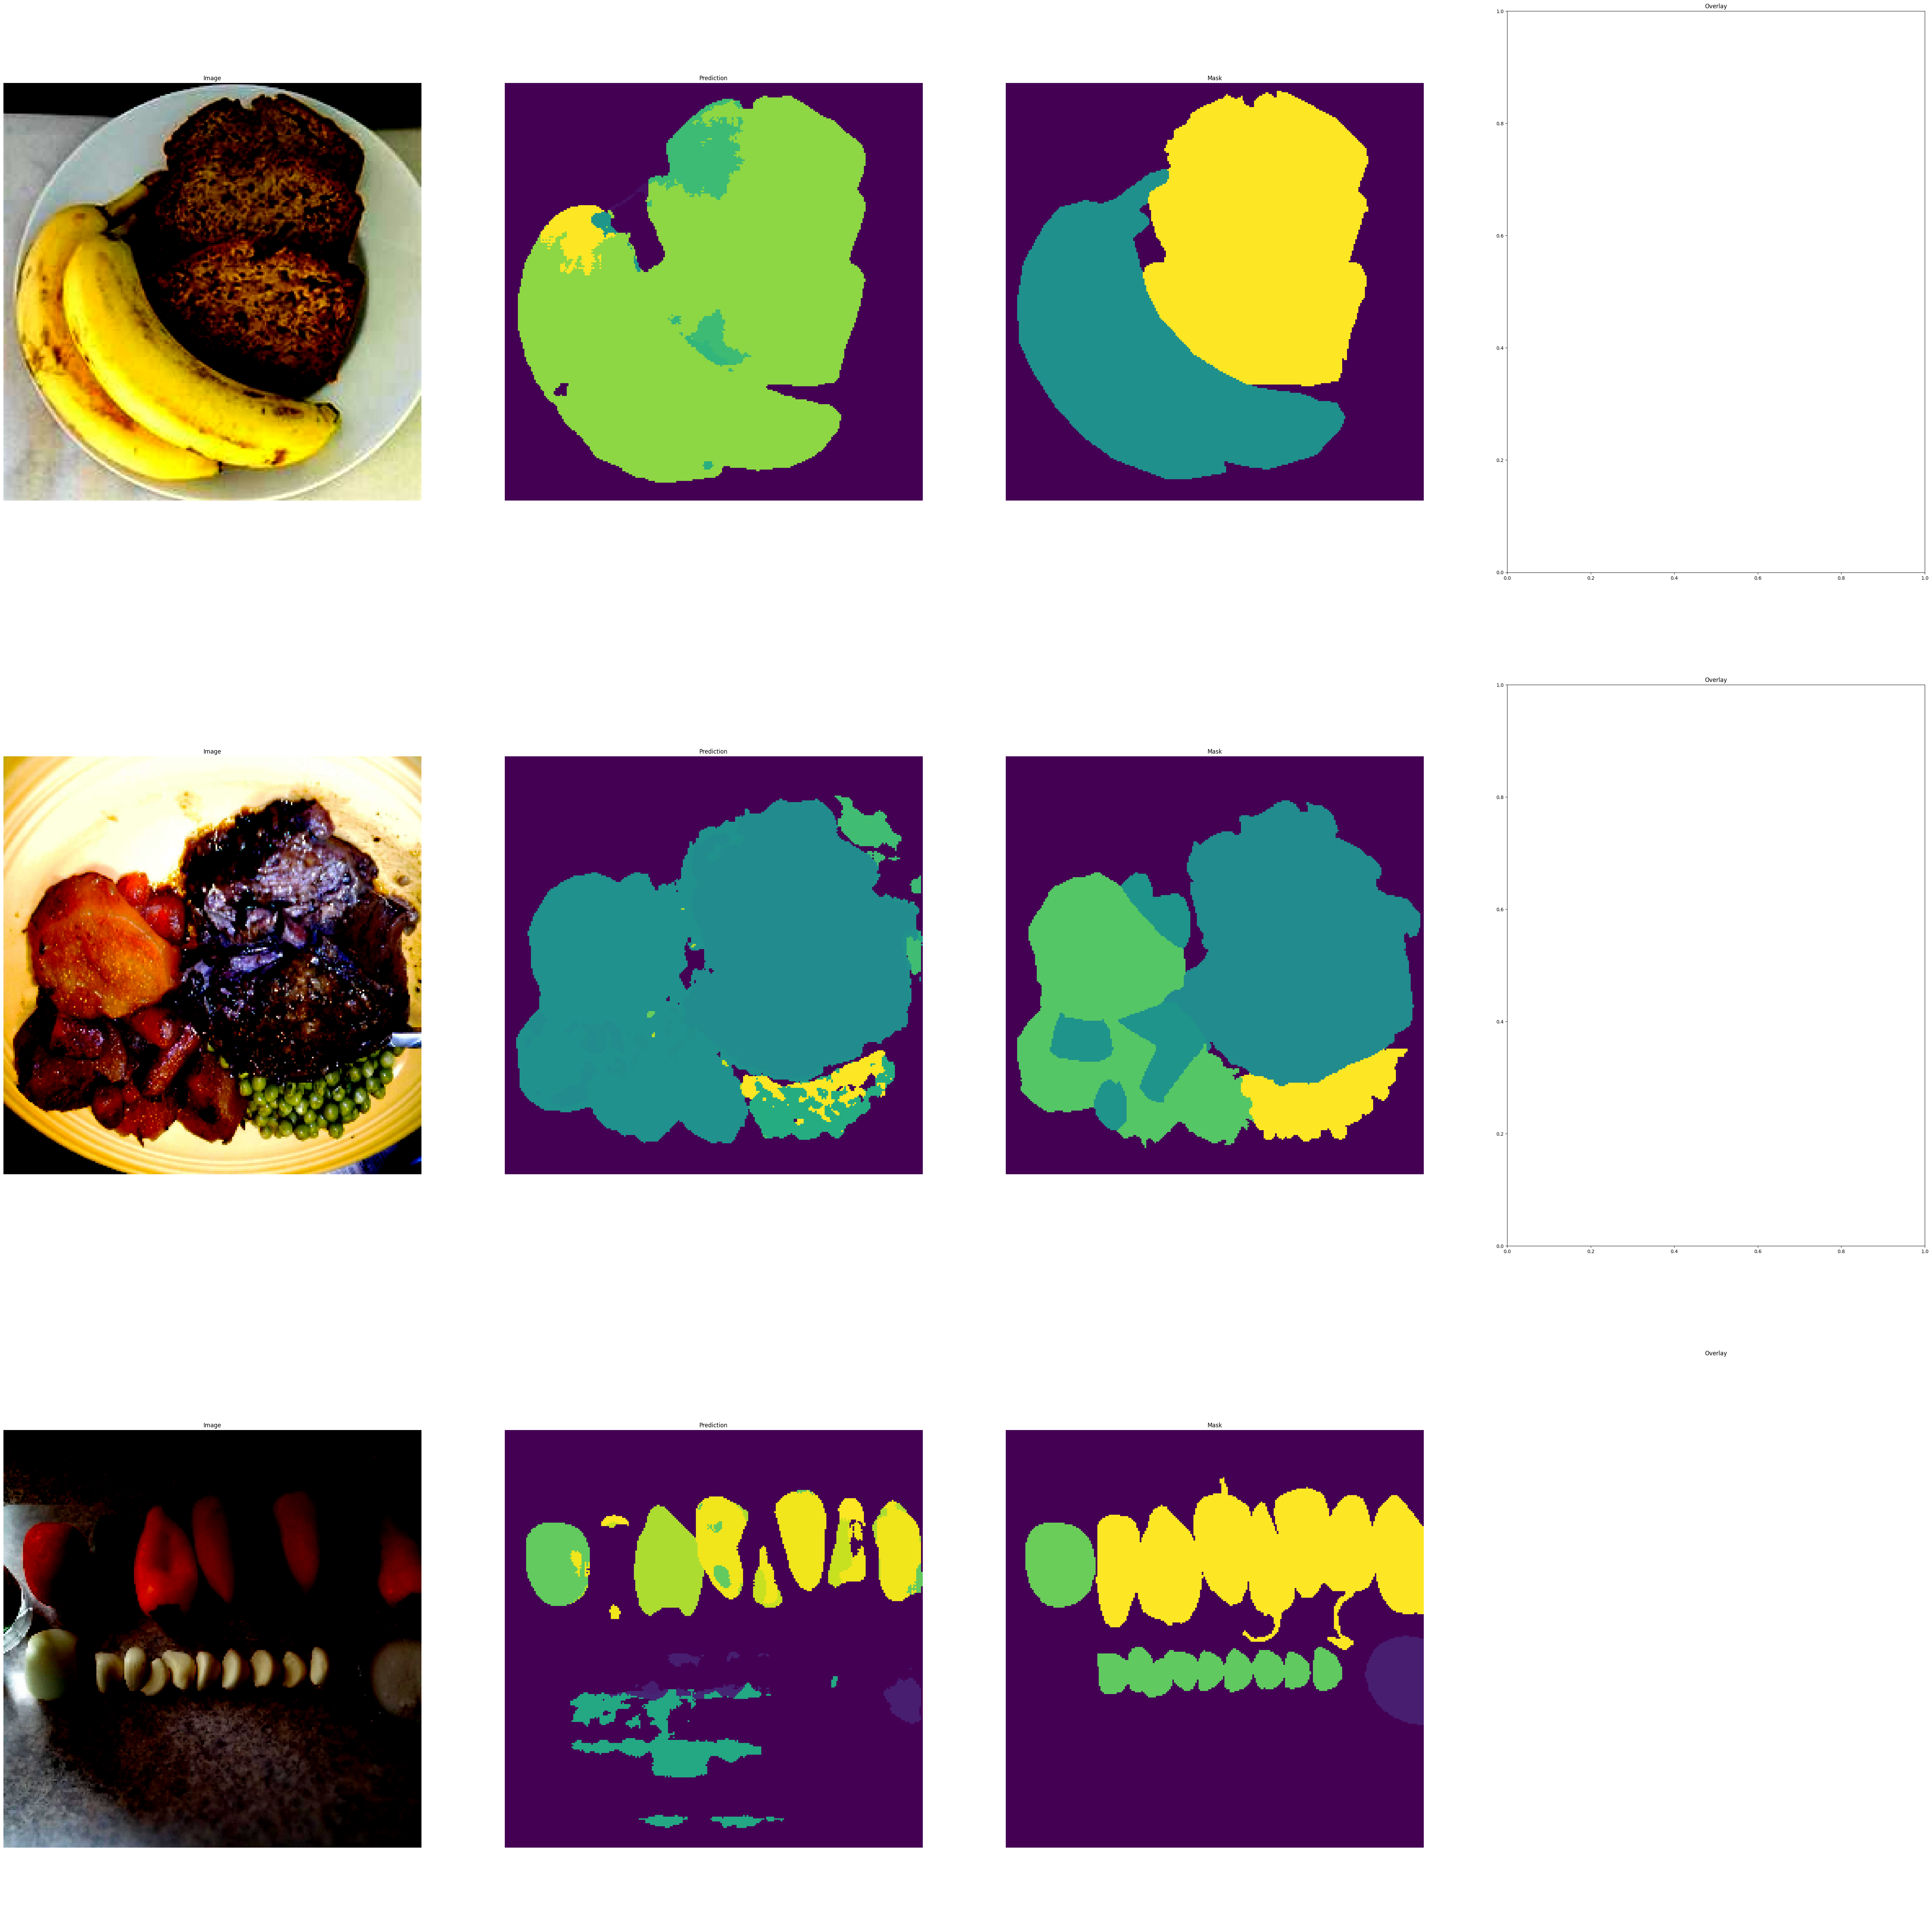

In [11]:

from skimage import color

for x,y in test_batch:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 4, figsize=(72, 72))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    print("Pred1", np.unique(preds1, return_counts=True))
    print("Mask1", np.unique(mask1))
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    # print("Pred2", np.unique(preds2))

    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    # print("Pred3", np.unique(preds3))

    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[0,3].set_title('Overlay')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[1,3].set_title('Overlay')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[2,3].set_title('Overlay')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[2][3].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    # ax[0][3].imshow(color.label2rgb(mask1, img1, saturation=1, alpha=0.5, bg_color=None))

    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)
    break